<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/08_Encodings_para_texto_y_LDA_%5BOpcional%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encodings for text and LDA

In this notebook, we will use the combined melbourn and airbnd dataframe, which contains Melbourne property sales data from [this Kaggle competition](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot), to which a column with neighborhood descriptions extracted from [a dataset of scrapings](https://www.kaggle.com/tylerx/melbourne-snapshot) was added.

In [22]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [23]:
# This allows us to print more information per column
pandas.set_option('display.max_colwidth', 500)

In [24]:
melb_df = pandas.read_csv("../data/melb_extended_neighborhood_overview.csv")
melb_df.sample(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,closest_airbnb_neighborhood_overview
1415,Brunswick West,24 Burnell St,3,h,1245000.0,S,Barry,14/05/2016,5.9,3055.0,...,1.0,412.0,NaN,1934.0,Moreland,-37.76180,144.94550,Northern Metropolitan,7082.0,"\n\nNear Sydney Rd, Melville rd tram to city, royal park zoo , tram goes past the botanical gardens and the Yarra also.\n15 minute walk to the vibrant Sydney Road shopping strip. The local Turkish and other middle eastern restaurants have been Melbourne favourites for many years and you can find a wide variety of other eateries these days. Other favourite local spots within walking distance include: - The Grandview Pub (Wednesday night trivia) - John Gorilla Cafe - Lux Foundry Cafe Popular..."
1225,Brighton East,25 Robinson St,4,h,2150000.0,S,Buxton,19/11/2016,10.7,3187.0,...,2.0,614.0,225.0,1970.0,Bayside,-37.91860,145.01750,Southern Metropolitan,6938.0,"We are in a lovely quiet neighbourhood but still quite close to both Church and Bay Street.\nBeautiful homes, beautiful beaches, walking tracks, parks, cafe's and restaurants.\nBrighton is one of the richest and safest suburbs, and a perfect location to explore Melbourne.\n\n\n\nA quiet and beautiful tree lined one way street\nClose to the beach, great shopping strips, very safe neighbourhood, family friendly\nOur home sits right in the middle of Brighton East Village where cafes are incredi..."
13438,Greensborough,53 Greenhill Rd,4,h,950000.0,S,hockingstuart,26/08/2017,16.1,3088.0,...,3.0,795.0,NaN,NaN,NaN,-37.69594,145.11734,Northern Metropolitan,8524.0,Greensborough is a nice quiet suburb. Our townhouse is located on a main street which can be busy. We are located near a bushy reserve with walking tracks nearby. There are lots of shops in Greensborough Plaza and on main street. We are not far from Eltham main street or Bundoora. All these places have great restaurants and cafes.\nIt is a family environment\n\nOUR NEIGHBOURHOOD IS A SMALL ESTATE WITH 51 HOUSES. OUR NEIGHBOURS ALL RESPECT EACH OTHER.WE LIVE ON TOP OF A HILL WITH SOME LOVELY ...


## Exploring free text

Unstructured data, such as free text or images, have specific methods to be able to analyze them. In this notebook we will try to understand what kind of information neighborhood descriptions give us, and if it can be useful in our price prediction task.

It is useful to know how much text we have per instance, to start estimating the amount of information represented and some characteristics of the documents. For example: it is not the same to analyze Tweets as it is to analyze Wikipedia documents.

/user/nocampo/home/miniconda3/envs/sald/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of number of characters for neighborhood reviews')

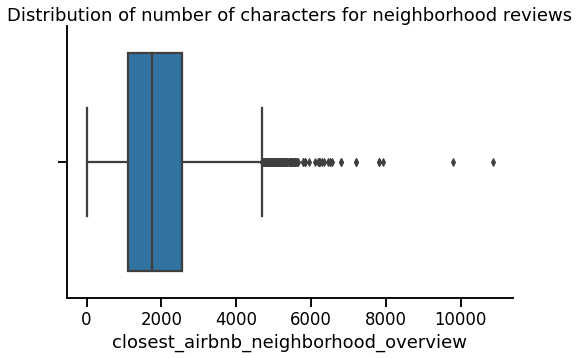

In [25]:
plt.figure(figsize=(8, 5))
seaborn.boxplot(melb_df.closest_airbnb_neighborhood_overview.apply(len))
seaborn.despine()
plt.title("Distribution of number of characters for neighborhood reviews")

## Word frequency analysis

### Word Clouds by CouncilArea

A good visual representation to understand what a text is about are word clouds.

In [26]:
def sample_text_from_col(df, n=100,
                         text_col='closest_airbnb_neighborhood_overview'):
  """Extract a sample of text from column"""
  if n > len(df):
    n = len(df)
  return '\n'.join(df.sample(n)[text_col].values)

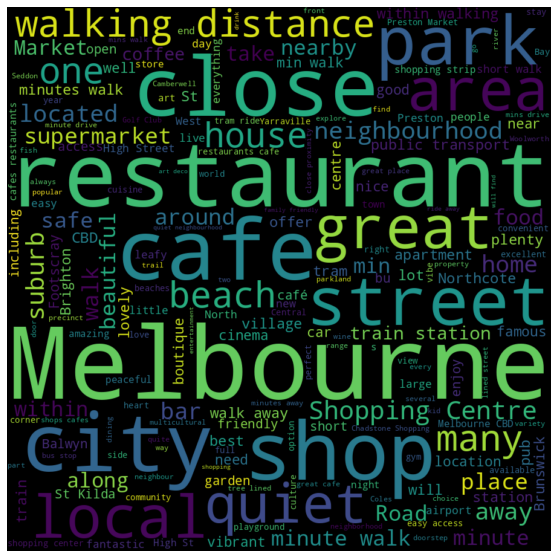

In [27]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text_sample = sample_text_from_col(melb_df)
wc = WordCloud(width=900, height=900, max_font_size=200).generate(text_sample)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

We can now create word clouds for the CouncilArea descriptions

In [28]:
unique_council_areas = melb_df.CouncilArea.unique()
text_samples_for_areas = {
    area: sample_text_from_col(melb_df[melb_df.CouncilArea == area])
    for area in unique_council_areas
    if isinstance(area, str)
}
list(text_samples_for_areas.keys())

['Yarra',
 'Moonee Valley',
 'Port Phillip',
 'Darebin',
 'Hobsons Bay',
 'Stonnington',
 'Boroondara',
 'Monash',
 'Glen Eira',
 'Whitehorse',
 'Maribyrnong',
 'Bayside',
 'Moreland',
 'Manningham',
 'Banyule',
 'Melbourne',
 'Kingston',
 'Brimbank',
 'Hume',
 'Knox',
 'Maroondah',
 'Casey',
 'Melton',
 'Greater Dandenong',
 'Nillumbik',
 'Whittlesea',
 'Frankston',
 'Macedon Ranges',
 'Yarra Ranges',
 'Wyndham',
 'Cardinia',
 'Unavailable',
 'Moorabool']

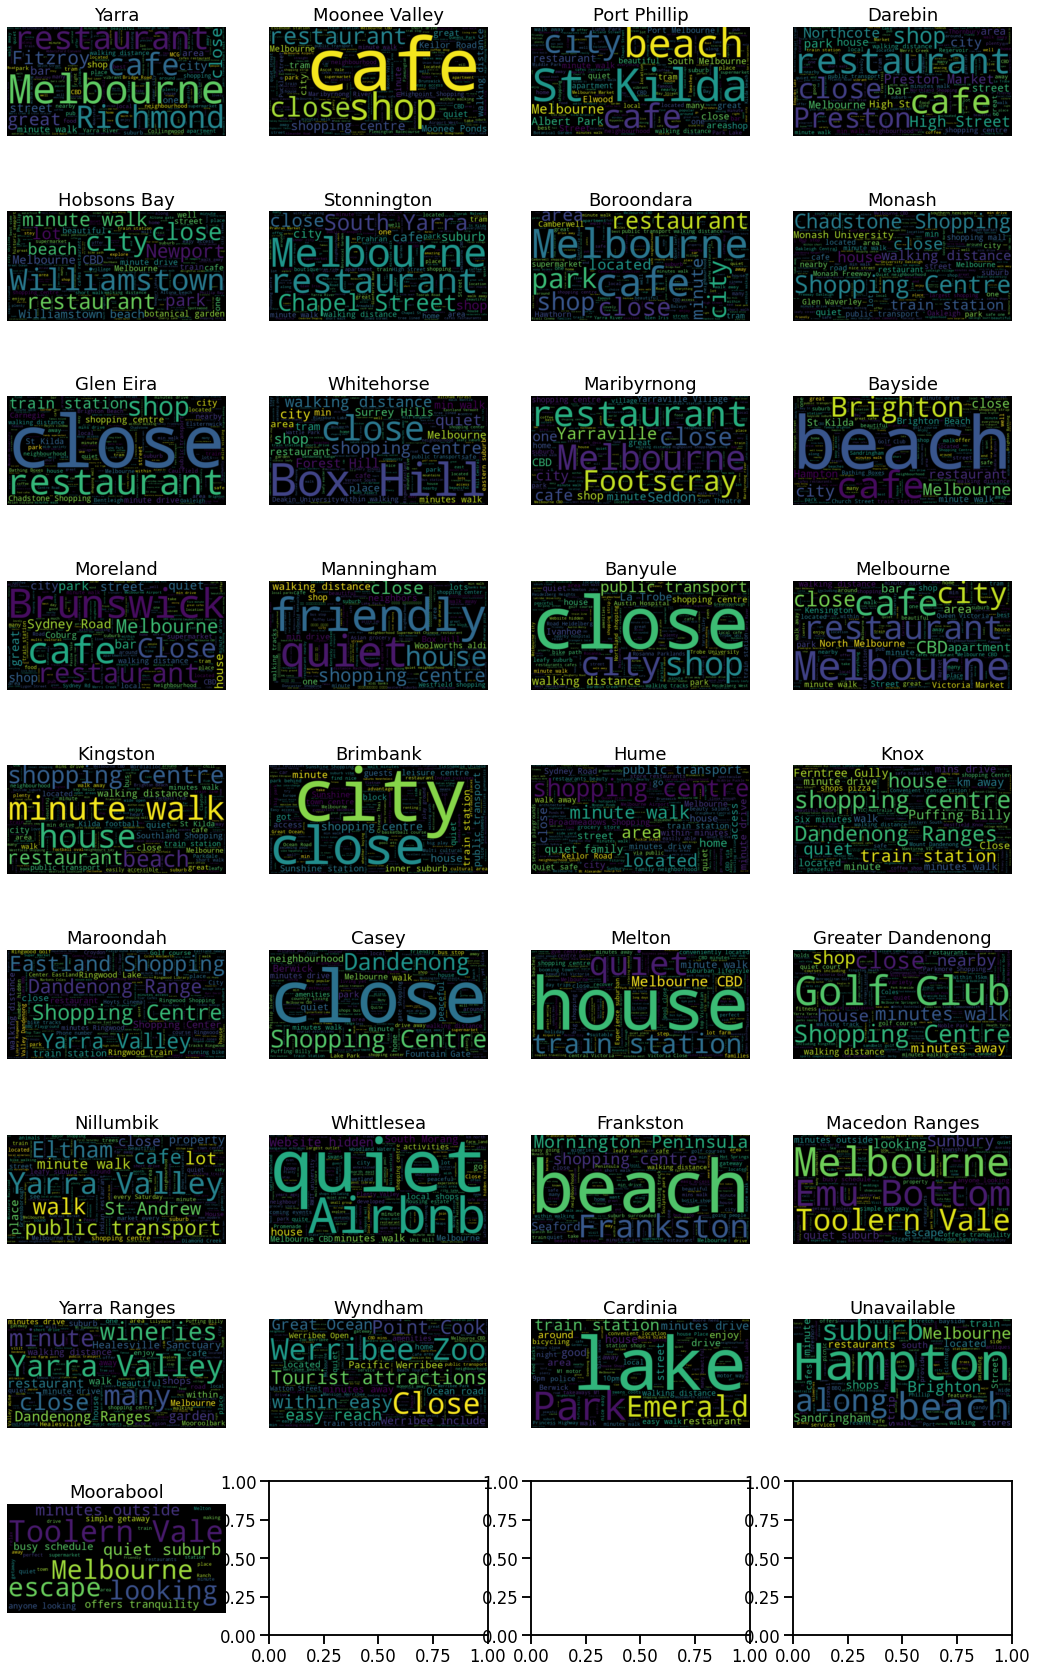

In [29]:
import math
# Create general layout
n_cols = 4
n_rows = math.ceil(len(text_samples_for_areas) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 30))
for i, (area, text_sample) in enumerate(text_samples_for_areas.items()):
  wc = WordCloud(width=600, height=300, max_font_size=200)\
      .generate(text_sample)
  row = math.floor(i / n_cols)
  col = i % n_cols
  ax = axs[row, col]
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(area)

## Encoding variables with free text

Although word clouds are very intuitive, we cannot use them to perform numerical analysis. In the same way as categorical data, textual data needs to be encoded in vectors.

In this mini-introduction we will use an encoding of *bag of words* or bag-of-words in English. Sean:
1. $W$ is the set of words called *vocabulary*, and let $M = |W|$ be its size. That is, there are $M$ different words in our documents.
2. $w_i \in W $ the word number $i$ of the vocabulary.

Using scikit-learn's `CountVectorizer` class, the document is cast to a vector $v \in \mathbb{R}^{M}$ where each column $i$ is filled with the number of times each word $w_i$ occur in the document.

To avoid an explosion of dimensions, we will limit the size of the vocabulary to only the most frequent words. In addition to this, the most frequent words of a language, such as "he", "of", are very uninformative. They are called *stopwords*. For this reason, they are generally ignored in these types of representations.

Note: This representation is one of the simplest to obtain, however, there are other more suitable projections.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
vocab_size = 500  ## Only 500 most frequent words
vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english')
tokens = vectorizer.fit_transform(melb_df.closest_airbnb_neighborhood_overview)

In [32]:
vectorizer.get_feature_names()[:15]

/user/nocampo/home/miniconda3/envs/sald/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10',
 '11',
 '12',
 '15',
 '1km',
 '20',
 '25',
 '30',
 '5km',
 'access',
 'accessible',
 'acland',
 'airbnb',
 'airport',
 'albert']

In [33]:
tokens.todense()

matrix([[ 2,  2,  0, ...,  0,  0,  0],
        [ 8,  0,  0, ...,  0,  0,  0],
        [15,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 1,  0,  0, ...,  0,  0,  0],
        [ 3,  0,  0, ...,  0,  0,  0]])

Podemos ver la frecuencia de cada palabra

In [34]:
word_frequencies = pandas.DataFrame(
    data={'frequency': tokens.sum(axis=0).flatten().tolist()[0],
                                     'tokens': vectorizer.get_feature_names()})
word_frequencies.sort_values('frequency')

,frequency,tokens
492,916,woolworth
113,916,cuisine
132,917,doncaster
94,917,clothing
466,919,use
...,...,...
65,29747,cafes
394,30963,shopping
373,31122,restaurants
479,39023,walk


## Dimensionality reduction

The vectors that represent each of our comments do not help us to understand the data, because we cannot think in hundreds of dimensions at the same time. They are too *counterintuitive*.

We can try to apply a method like PCA to reduce the dimensionality of vectors, but this will not return vectors that we can read or understand.

Fortunately, there are ways to transform them into representations that are more *human-friendly*.

[LDA](https://scikit-learn.org/stable/modules/decomposition.html?highlight=lda#latent-dirichlet-allocation-lda) or Latent Dirichlet Allocation is a model that assumes that each text talks about a topic or unknown *topic*.

When it is trained, it finds groups of words (vectors) that correspond to the topics that would best explain the data.

In [35]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(tokens)

LatentDirichletAllocation(n_components=5, random_state=0)

In [36]:
feature_names = vectorizer.get_feature_names()
feature_names[:20]

/user/nocampo/home/miniconda3/envs/sald/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10',
 '11',
 '12',
 '15',
 '1km',
 '20',
 '25',
 '30',
 '5km',
 'access',
 'accessible',
 'acland',
 'airbnb',
 'airport',
 'albert',
 'aldi',
 'amazing',
 'amenities',
 'apartment',
 'approximately']

In [37]:
def plot_top_words(model, feature_names, n_top_words=10, title=''):
    n_cols = 2
    n_rows = math.ceil(model.n_components / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

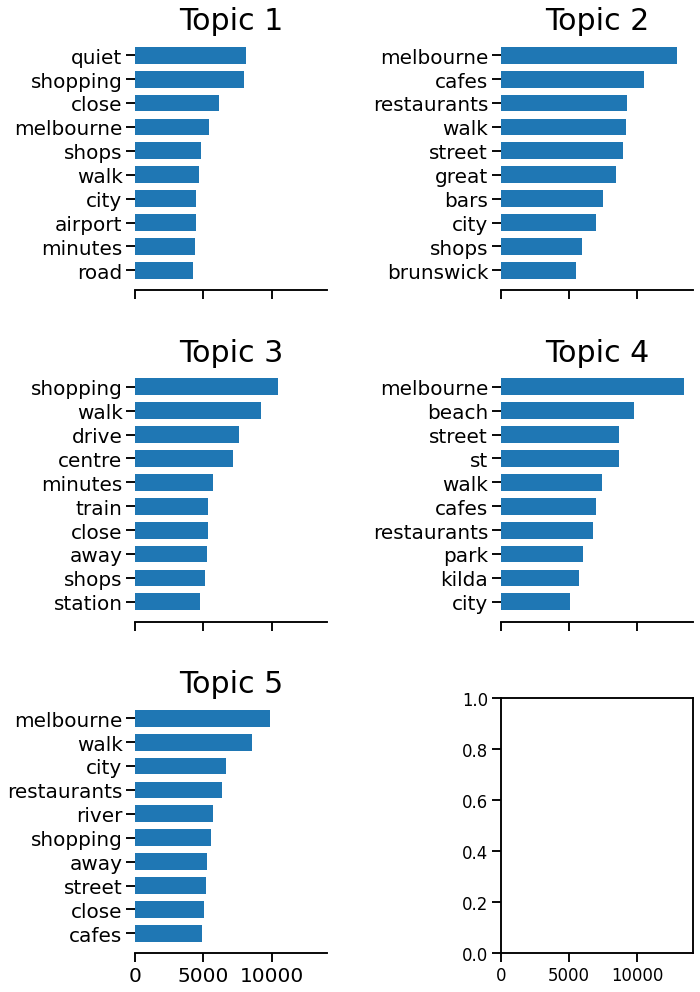

In [38]:
plot_top_words(lda, feature_names)

Now we can use the model to determine what is the probability that a text will be generated by that topic. That is, "how much of topic X does the document talk about?"

In [39]:
lda_columns = ['topic{}'.format(i) for i in range(lda.n_components)]
melb_df[lda_columns] = lda.transform(tokens)

In [40]:
melb_df[['closest_airbnb_neighborhood_overview'] + lda_columns].sample()

,closest_airbnb_neighborhood_overview,topic0,topic1,topic2,topic3,topic4
12142,"Right in the heart of Richmond, the home is just steps from the train station and Swan Street, one of the country's hottest food destinations. Walk to the Melbourne Sports and Entertainment Precinct, Yarra River, and Royal Botanical Gardens.\nThis inner-west vicinity has it all, from shopping strip Bridge Road, to the villagey Swan Street. Multicultural Richmond is best known for Victoria Street, or “Little Saigon”, with its bustling Asian grocery stores and eateries serving pho and bánh mì....",0.001461,0.190348,0.001457,0.129847,0.676887


Now we can see the correlations between the topics and the rest of the variables in our data set. We can see that there is a certain correlation between the first topic with some of the possible values for CouncilArea

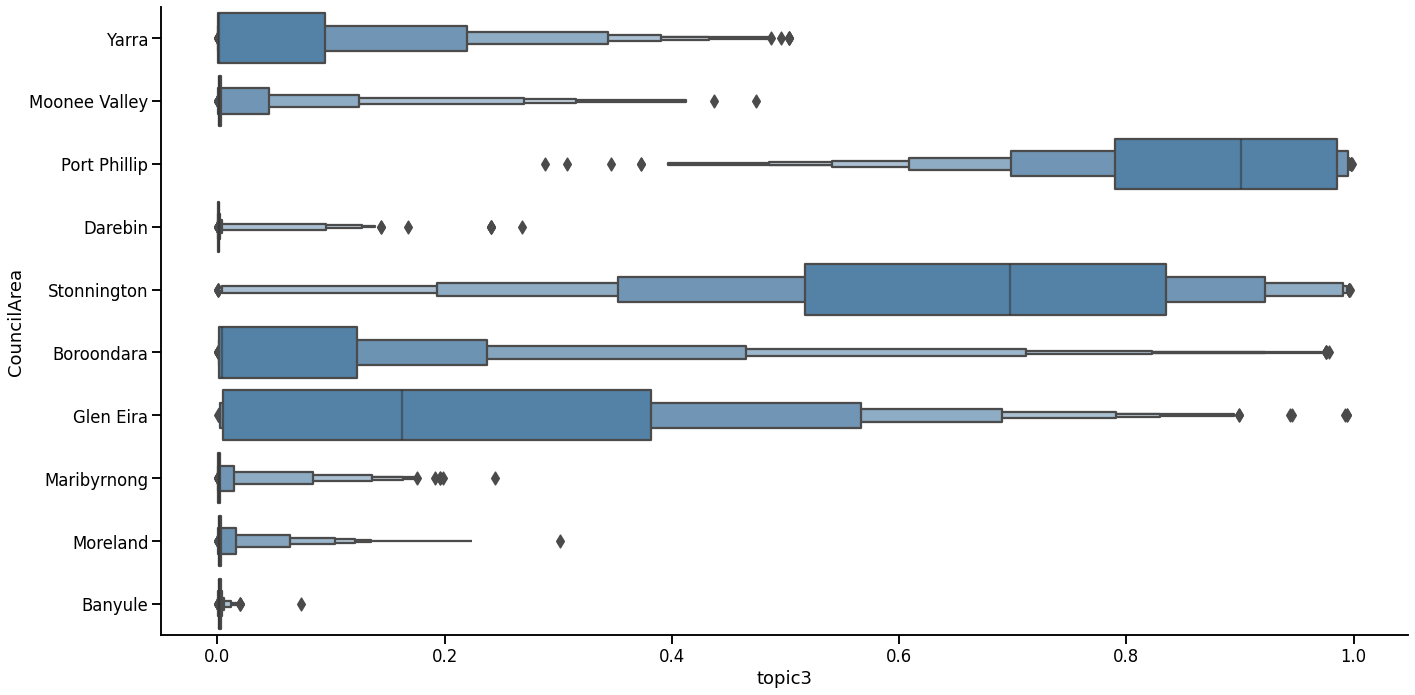

In [41]:
most_common_areas = melb_df.CouncilArea.value_counts()[:10].index
seaborn.catplot(data=melb_df[melb_df.CouncilArea.isin(most_common_areas)],
                x='topic3', y='CouncilArea', kind='boxen',
                height=10, aspect=2, color='steelblue')

Does it help us to better estimate the price of a property? If we plot the price distribution for each topic (taking only the most likely topic for each document), we don't see much variability.

In [42]:
melb_df['most_likely_topic'] = melb_df[lda_columns].values.argmax(axis=1)
melb_df[lda_columns + ['most_likely_topic']].head()

,topic0,topic1,topic2,topic3,topic4,most_likely_topic
0,0.000458,0.239827,0.048415,0.000457,0.710844,4
1,0.000307,0.477759,0.000308,0.044790,0.476835,1
2,0.000295,0.594901,0.000295,0.082541,0.321968,1
3,0.025602,0.191831,0.105826,0.000408,0.676333,4
4,0.000379,0.515925,0.000381,0.000382,0.482933,1


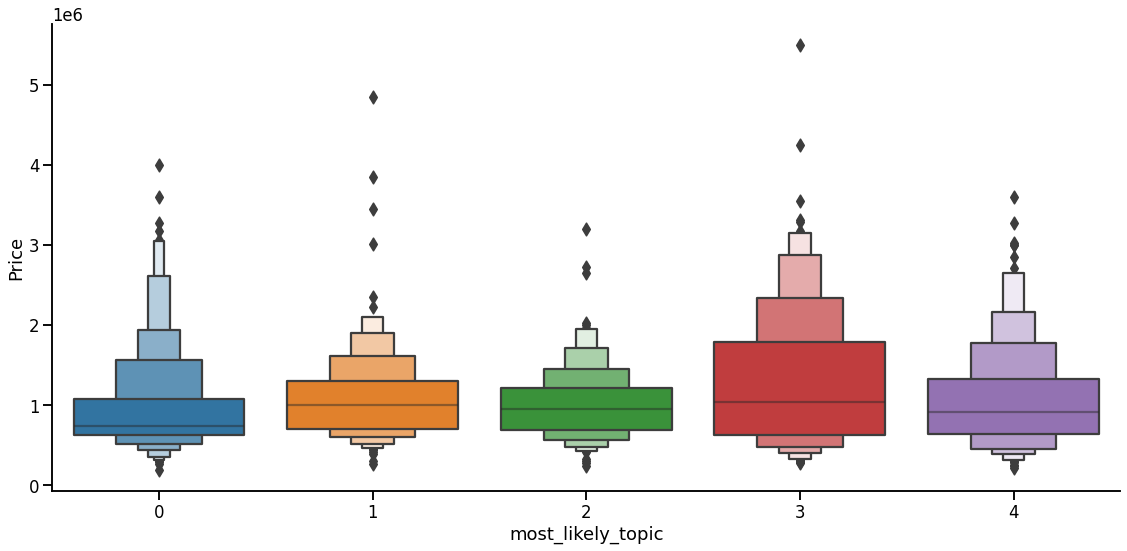

In [43]:
seaborn.catplot(data=melb_df.sample(1000),
                x='most_likely_topic', y='Price',# hue='Type',
                kind='boxen',
                height=8, aspect=2)